In [ ]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

train_dataset_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
test_dataset_path = 'dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)



In [ ]:
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y
# 위의 과정을 통해 Flow ID라는 int 형태가 될 수 없는 데이터와
# y로 분리되어 있는 Label을 제외한 나머지 데이터는 모두 숫자형으로 변환된다.

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

print("Train 데이터 레이블 분포:")
print(pd.Series(y_train).value_counts())
print("-" * 50)
print("Test 데이터 레이블 분포:")
print(pd.Series(y_test).value_counts())

Train 데이터 크기: (692703, 83)
Test 데이터 크기: (225745, 83)
--------------------------------------------------
Train 데이터 레이블 분포:
0    440031
1    252672
Name: count, dtype: int64
--------------------------------------------------
Test 데이터 레이블 분포:
1    128027
0     97718
Name: count, dtype: int64


In [ ]:

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM 입력 형태에 맞게 데이터 재구성 (samples, timesteps, features)
# 여기서는 각 샘플을 1개의 타임스텝으로 간주
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



## LSTM 모델 학습 및 평가 ##


In [8]:
# 가중치 부여
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: 0.7871070447309394, 1: 1.3707553666413375}


In [ ]:
# LSTM 모델 정의 및 하이퍼파라미터 튜닝
lstm_model = KerasClassifier(build_fn=create_lstm_model)

grid_params = {
    'epochs': [10, 25, 50],
    'batch_size': [32, 64]
}
grid_search = GridSearchCV(estimator=lstm_model, param_grid=grid_params, cv=3, scoring='f1' , verbose=1)
grid_search.fit(X_train_lstm, y_train, class_weight=class_weights_dict)

print("최적의 파라미터:", grid_search.best_params_)
lstm_best_model = grid_search.best_estimator_

NameError: name 'KerasClassifier' is not defined

In [ ]:
## 최적의 하이퍼파라미터로 재학습
import time

start_time = time.time()
lstm_best_model.fit(X_train_lstm, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'])
end_time = time.time()
print(f"모델 학습 시간: {end_time - start_time:.4f} 초")

Epoch 1/50
18400/18400 [==============================] - 34s 2ms/step - loss: 0.0379 - accuracy: 0.9871
Epoch 2/50
18400/18400 [==============================] - 32s 2ms/step - loss: 0.0159 - accuracy: 0.9958
Epoch 3/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0146 - accuracy: 0.9962
Epoch 4/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0137 - accuracy: 0.9964
Epoch 5/50
18400/18400 [==============================] - 32s 2ms/step - loss: 0.0132 - accuracy: 0.9965
Epoch 6/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0125 - accuracy: 0.9967
Epoch 7/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0121 - accuracy: 0.9967
Epoch 8/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0119 - accuracy: 0.9968
Epoch 9/50
18400/18400 [==============================] - 33s 2ms/step - loss: 0.0116 - accuracy: 0.9969
Epoch 10/50
18400/18400 [==============================

In [ ]:

# 모델 평가
#loss, accuracy = lstm_best_model.model_.evaluate(X_test_lstm, y_test, verbose=0)
y_pred_lstm_proba = lstm_best_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print("[LSTM 모델 최적화 결과]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_score(y_test, y_pred_lstm):.4f}")
print(f" - 재현율 (Recall): {recall_score(y_test, y_pred_lstm):.4f}")
print(f" - F1-Score: {f1_score(y_test, y_pred_lstm):.4f}")
print(f" - 학습 시간: {end_time - start_time:.4f}초")
print("-" * 50)


3248/3248 [==============================] - 3s 862us/step
[LSTM 모델 최적화 결과]
 - 하이퍼파라미터: {'Epochs': 50, 'Batch Size': 32}
 - 정확도 (Accuracy): 0.9971
 - 재현율 (Recall): 0.9998
 - F1-Score: 0.9961
 - 학습 시간: 1640.7398초
--------------------------------------------------


Text(0.5, 1.0, 'ROC Curve for LSTM Model')

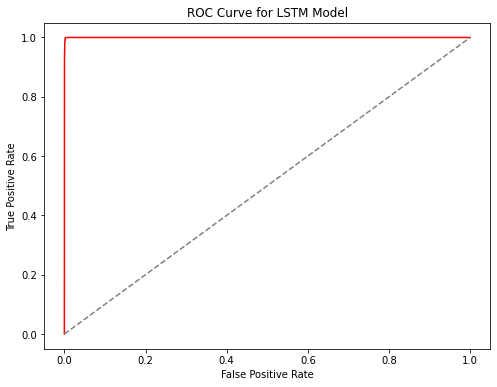

In [11]:
## ROC 곡선 및 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'LSTM (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('ROC Curve for LSTM Model')

In [ ]:
import joblib
import os

save_path = 'models/lstm_model.h5'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

lstm_best_model.model_.save(save_path)
print(f"LSTM 모델이 {save_path}에 저장되었습니다.")


NameError: name 'lstm_best_model' is not defined